This page presents the results of Bayesian hierarchical model that looks at all previous elections and tries to predict them based on two main sources of information: the polls and the unemployment rate in Paris. The nice thing is that the model gives us estimates for each party, in each district of Paris, which is, to the best of my knowledge, the first one to do that and with this depth of data. 

This page focuses on analyzing and plotting the results. So, you don't have to _understand_ the model to understand what it's telling us. But, if you're curious about it, please go ahead and [check out the code and data]() I used to get there!

Now, I could analyze the most important parameters in the model, what they mean and how this relates to the political science of Paris. But I'm not gonna do that -- at least not in a first draft of this analysis. As I want this notebook to be accessible to not-so-technical folks, I'll focus on vizualisations -- and as this model has hundreds of dimensions and parameters, I think it's also better than staring at a table of coefficients.

So, without further ado, let's look at our first plot!

In [1]:
import arviz as az
import bokeh.plotting as bkp
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from bokeh.io import output_notebook, show
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.models.annotations import Title
from bokeh.models.widgets import Select
from bokeh.palettes import brewer, cividis
from bokeh.transform import linear_cmap

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
Nparties = len(PARTIES) - 1
Ndistricts = 20

In [2]:
az.style.use("arviz-darkgrid")
output_notebook()

share_est = np.load("oos_data/post_share_est.npz")["share_est"]
share_mean = share_est.mean(1)

Loading BokehJS ...

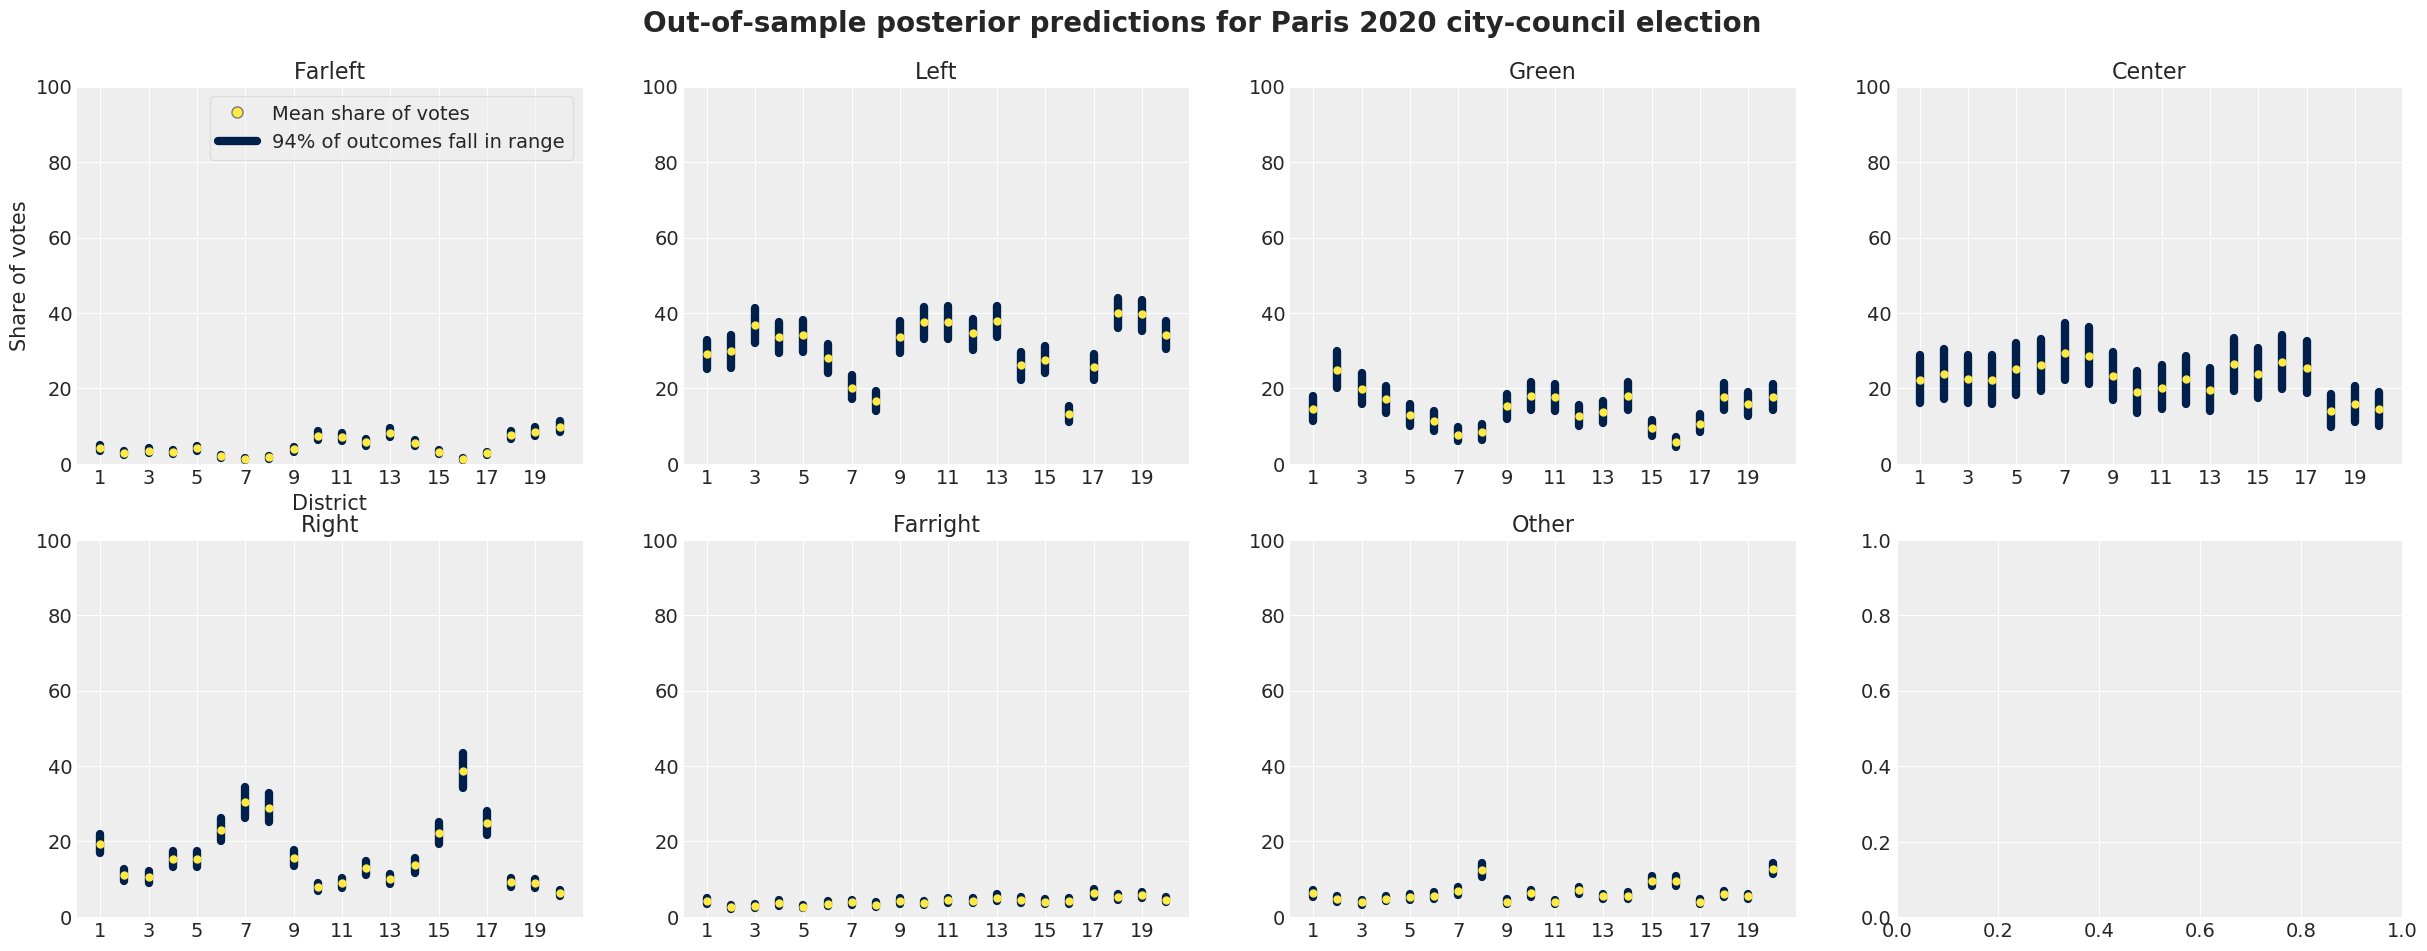

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, :, i].T).T,
            color=cividis(3)[0],
            lw=6,
        )
        ax.plot(
            np.arange(Ndistricts), share_mean[:, i], "o", color=cividis(3)[2], ms=5,
        )
        ax.set_xticks(range(Ndistricts)[::2])
        ax.set_xticklabels(range(1, Ndistricts + 1)[::2])
        ax.set_title(f"{PARTIES[i].title()}")
        ax.set_ylim([-0.05, 100.0])
        if i == 0:
            ax.set_xlabel("District")
            ax.set_ylabel("Share of votes")
            ax.plot(
                [],
                "o",
                markeredgecolor=cividis(3)[1],
                markeredgewidth=1,
                color=cividis(3)[2],
                ms=8,
                label="Mean share of votes",
            )
            ax.plot(
                [], label="94% of outcomes fall in range", color=cividis(2)[0], lw=6
            )
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    "Out-of-sample posterior predictions for Paris 2020 city-council election",
    y=0.95,
    size=20,
    weight="bold",
);

This graph displays the model's estimation of each party's strength in each district. The yellow points are the mean estimates, and the blue bars are the 94% compatibility interval -- in the small world of the model, there is a 94% chance that the true result will fall in this range; of course, a model is a reduction of reality, so there usually is more uncertainty than just the one the model tells us about. But it should be a good rule of thumb (if I did a good job!) and it allows us to compare the uncertainty across districts and parties.

We already see the big favorites: left, center and right, by descending order. The centrist party is the one with the biggest uncertainty. I think this is mostly due to the fact that this party was a semi-fringe one before 2017 and Emmanuel Macron. So, we don't have a lot of data to estimate its chances -- just think that for the last city-council elections, in 2014, the centrist party was so weak that they didn't compete; and now, it's the president's party, which accounts for a sizeable share of the electorate, especially in Paris. 

I'll expand a little on this analysis in future iterations of this notebook, but for now let's plot the model's expectations on a map of Paris! This is done by the code below, in big part thanks to Grégoire David and [his awesome open-source project, france-geojson](https://github.com/gregoiredavid/france-geojson), where I found the geographic shapes of Paris.

In [4]:
paris_shape = gpd.read_file("oos_data/paris_shape.geojson")
geosource = GeoJSONDataSource(geojson=paris_shape.to_json())

In [5]:
p = bkp.figure(
    title="Predictions by district for Paris 2020 city-council election",
    align="center",
    plot_height=350,
    plot_width=600,
    sizing_mode="scale_both",
    title_location="above",
    tools="",
    toolbar_location=None,
)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = False
p.outline_line_color = None
p.title.align = "center"
p.title.text_font_size = "1.4rem"
p.background_fill_color = "#e6e6e6"
p.border_fill_color = "#e6e6e6"

palette = brewer["Greys"][7][::-1]
color_mapper = LinearColorMapper(palette=palette, low=0, high=75)
# custom tick labels for color bar:
tick_labels = {
    "0": "0",
    "10": "15",
    "20": "25",
    "30": "35",
    "40": "45",
    "50": "55",
    "60": "65",
    "70": "75+% of votes",
}
color_bar = ColorBar(
    background_fill_color="#e6e6e6",
    border_line_color=None,
    color_mapper=color_mapper,
    height=400,
    label_standoff=18,
    major_label_overrides=tick_labels,
    orientation="vertical",
    padding=0,
    title="7 Shades of Grey",
    title_standoff=4,
    width=20,
)
# TO DO: LEGEND
# http://docs.bokeh.org/en/latest/docs/reference/models/annotations.html?highlight=legend#bokeh.models.annotations.Legend
# https://docs.bokeh.org/en/latest/docs/user_guide/styling.html#legends
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# https://stackoverflow.com/questions/54826102/bokeh-how-to-add-legend-to-patches-glyph-with-geojsondatasource-and-categorical

district_shapes = p.patches(
    "xs",
    "ys",
    source=geosource,
    fill_color="color",
    fill_alpha=1,
    line_color="gray",
    line_width=0.75,
)
p.add_tools(
    HoverTool(
        renderers=[district_shapes],
        tooltips=[
            ("", "Paris, District @index"),
            ("Winner", "@winner, with @odds% chance"),
            ("Mean", "@mean{1.1} %"),
            ("94% HPD", "[@low{1.1} - @high{1.1}] % of votes"),
        ],
    )
)
p.add_layout(color_bar, "right")
show(p)

Lots of information on this map! You get a lot of detailed information when hovering over the districts: the expected winner of the district and its associated probability; the mean vote share; the 94% compatibility interval of vote shares. 

The color of each district indicates who is the projected winner -- here, only the right (blue), center (orange) and left (pink) parties are expected to win districts. In addition, each party's color is declined in shades. As indicated by the color bar to the right, the darker the color, the bigger the expected vote share for the party in the district. The center party is displayed in only one shades, which means its support is about the same in the corresponding districts. However, the Socialist party is stronger on the East side of Paris -- where it's mostly a huge favorite -- than in the center -- where its probabilities of winning are much slimmer and closer to the centrist party. 

More can be said about this map alone, but that will be for a later update of this page -- so, come back for more! Hope you enjoyed it, and [feel free to reach out](https://twitter.com/alex_andorra) for comments, suggestions and ideas!

_A huge thank you to [Junpeng Lao](https://twitter.com/junpenglao) for his numerous, patient and always relevant modeling advice! I will never thank enough all the [PyMC](https://docs.pymc.io/) and [ArviZ](https://arviz-devs.github.io/arviz/) developers, who work on their free time to give us access to fast, reliable and amazing scientific and computing tools. Finally, I want to thank Alexis Bergès, Bérengère Patault and Simon Bunel for their advice and support when the model wouldn't fit and the only solution seemed to be to throw my laptop out the window._